In [1]:
import itertools
import random
from collections import defaultdict

import numpy as np
import torch
import torch.nn.functional as F
from networkx.algorithms.centrality import degree_centrality
from scipy.stats import entropy
from torch.nn import Linear
from torch.nn import functional as F
from torch.nn.functional import cosine_similarity
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import BatchNorm, MessagePassing, TopKPooling
from torch_geometric.transforms import NormalizeFeatures
from torch_scatter import scatter_mean

from custom.args import grey, purple
from custom.dataset import GraphDataset, create_dataset
from custom.utils import *

import torch
import torch.nn.functional as F
import numpy as np
from torch import Tensor
from typing import Optional, Tuple, Union, Callable

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn.resolver import activation_resolver


def calculate_scores(x, weight, activation):
    score = (x * weight).sum(dim=-1)
    score = activation(score / weight.norm(p=2, dim=-1))
    return score

In [3]:
class GraphMatchingConvolution(MessagePassing):
    def __init__(self, in_channels, out_channels, args, aggr="add"):
        super(GraphMatchingConvolution, self).__init__(aggr=aggr)
        self.args = args
        self.lin_node = torch.nn.Linear(in_channels, out_channels)
        self.lin_message = torch.nn.Linear(out_channels * 2, out_channels)
        self.lin_passing = torch.nn.Linear(out_channels + in_channels, out_channels)
        self.batch_norm = BatchNorm(out_channels)

    def forward(self, x, edge_index, batch):
        x_transformed = self.lin_node(x)
        return self.propagate(edge_index, x=x_transformed, original_x=x, batch=batch)

    def message(self, edge_index_i, x_i, x_j):
        x = torch.cat([x_i, x_j], dim=1)
        m = self.lin_message(x)
        return m

    def update(self, aggr_out, edge_index, x, original_x, batch):
        n_graphs = torch.unique(batch).shape[0]
        cross_graph_attention, a_x, a_y = batch_block_pair_attention(
            original_x, batch, n_graphs
        )
        attention_input = original_x - cross_graph_attention
        aggr_out = self.lin_passing(torch.cat([aggr_out, attention_input], dim=1))
        aggr_out = self.batch_norm(aggr_out)

        norms = torch.norm(aggr_out, p=2, dim=1)
        cross_attention_sums = cross_graph_attention.sum(dim=1)

        return (
            aggr_out,
            edge_index,
            batch,
            (
                attention_input,
                cross_graph_attention,
                a_x,
                a_y,
                norms,
                cross_attention_sums,
            ),
        )


class GraphAggregator(torch.nn.Module):
    def __init__(self, in_channels, out_channels, args):
        super(GraphAggregator, self).__init__()
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.lin_gate = torch.nn.Linear(in_channels, out_channels)
        self.lin_final = torch.nn.Linear(out_channels, out_channels)
        self.args = args

    def forward(self, x, edge_index, batch):
        x_states = self.lin(x)
        x_gates = torch.nn.functional.softmax(self.lin_gate(x), dim=1)
        x_states = x_states * x_gates
        x_states = scatter_mean(x_states, batch, dim=0)
        x_states = self.lin_final(x_states)
        return x_states


class GraphMatchingNetwork(torch.nn.Module):
    def __init__(self, args):
        super(GraphMatchingNetwork, self).__init__()
        self.args = args
        self.margin = self.args.margin
        if args.n_classes > 2:
            self.f1_average = "micro"
        else:
            self.f1_average = "binary"
        self.layers = torch.nn.ModuleList()
        self.layers.append(
            GraphMatchingConvolution(self.args.feat_dim, self.args.dim, args)
        )
        for _ in range(self.args.num_layers - 1):
            self.layers.append(
                GraphMatchingConvolution(self.args.dim, self.args.dim, args)
            )
        self.aggregator = GraphAggregator(self.args.dim, self.args.dim, self.args)
        self.layer_outputs = []
        self.layer_cross_attentions = []
        self.mincut = []
        self.mlp = torch.nn.Sequential()
        self.args.n_clusters = args.n_clusters
        self.mlp.append(Linear(self.args.dim, self.args.n_clusters))
        self.topk_outputs = []
        self.norms_per_layer = []
        self.attention_sums_per_layer = []
        self.topk_pooling = TopKPooling(self.args.dim, ratio=0.99)

    def compute_emb(
        self, feats, edge_index, batch, sizes_1, sizes_2, edge_index_1, edge_index_2
    ):

        for i in range(self.args.num_layers):
            (
                feats,
                edge_index,
                batch,
                (
                    attention_input,
                    cross_graph_attention,
                    a_x,
                    a_y,
                    norms,
                    attention_sums,
                ),
            ) = self.layers[i](feats, edge_index, batch)

            x_1 = feats[: sizes_1.item(), :]
            x_2 = feats[sizes_1.item() : sizes_1.item() + sizes_2.item(), :]

            norms_1 = norms[: sizes_1.item()]
            norms_2 = norms[sizes_1.item() : sizes_1.item() + sizes_2.item()]

            attention_sums_1 = attention_sums[: sizes_1.item()]
            attention_sums_2 = attention_sums[
                sizes_1.item() : sizes_1.item() + sizes_2.item()
            ]

            x_pooled_1, edge_index_pooled_1, _, _, perm1, score1 = self.topk_pooling(
                x_1,
                edge_index_1,
            )
            x_pooled_2, edge_index_pooled_2, _, _, perm2, score2 = self.topk_pooling(
                x_2,
                edge_index_2,
            )

            self.topk_outputs.append(
                (
                    (x_pooled_1, edge_index_pooled_1, perm1, score1),
                    (x_pooled_2, edge_index_pooled_2, perm2, score2),
                )
            )
            self.layer_cross_attentions.append((cross_graph_attention, a_x, a_y))
            self.layer_outputs.append((x_1, edge_index_1, x_2, edge_index_2))
            self.norms_per_layer.append((norms_1, norms_2))
            self.attention_sums_per_layer.append((attention_sums_1, attention_sums_2))

        feats = self.aggregator(feats, edge_index, batch)
        return feats, edge_index, batch

    def combine_pair_embedding(
        self, feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
    ):
        feats = torch.cat([feats_1, feats_2], dim=0)
        max_node_idx_1 = sizes_1.sum()
        edge_index_2_offset = edge_index_2 + max_node_idx_1
        edge_index = torch.cat([edge_index_1, edge_index_2_offset], dim=1)
        batch = create_batch(torch.cat([sizes_1, sizes_2], dim=0))
        feats, edge_index, batch = (
            feats.to(self.args.device),
            edge_index.to(self.args.device),
            batch.to(self.args.device),
        )
        return feats, edge_index, batch

    def forward(self, feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2):
        self.layer_outputs = []
        self.layer_cross_attentions = []
        self.topk_outputs = []
        self.mincut = []
        self.norms_per_layer = []
        self.attention_sums_per_layer = []

        feats, edge_index, batch = self.combine_pair_embedding(
            feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
        )
        emb, _, _ = self.compute_emb(
            feats, edge_index, batch, sizes_1, sizes_2, edge_index_1, edge_index_2
        )
        emb_1 = emb[: emb.shape[0] // 2, :]
        emb_2 = emb[emb.shape[0] // 2 :, :]

        best_acc1, best_acc2 = 0.0, 0.0
        cluster1, cluster2 = None, None
        layer1, layer2 = None, None
        for i in range(len(self.topk_outputs)):
            (
                (x_pooled_1, edge_index_pooled_1, perm1, score1),
                (x_pooled_2, edge_index_pooled_2, perm2, score2),
            ) = self.topk_outputs[i]
            acc1 = len(set(range(8)) & set(perm1.tolist()))
            acc2 = len(set(range(8)) & set(perm2.tolist()))
            if acc1 > best_acc1:
                cluster1 = Data(x=x_pooled_1, edge_index=edge_index_pooled_1)
                best_acc1 = acc1
                layer1 = i + 1
            if acc2 > best_acc2:
                cluster2 = Data(x=x_pooled_2, edge_index=edge_index_pooled_2)
                best_acc2 = acc2
                layer2 = i + 1

        return emb_1, emb_2, cluster1, cluster2, layer1, layer2

    def compute_metrics(self, emb_1, emb_2, labels):
        distances = torch.norm(emb_1 - emb_2, p=2, dim=1)
        loss = F.relu(self.margin - labels * (1 - distances)).mean()
        predicted_similar = torch.where(
            distances < self.args.margin,
            torch.ones_like(labels),
            -torch.ones_like(labels),
        )
        acc = (predicted_similar == labels).float().mean()
        metrics = {"loss": loss, "acc": acc}
        return metrics

    def init_metric_dict(self):
        return {"acc": -1, "f1": -1}

    def has_improved(self, m1, m2):
        return m1["acc"] < m2["acc"]

Total number of graphs: 360
Number of classes: 4
Number of node features: 4
Average number of nodes per graph: 18
Max number of nodes in a graph: 19
Min number of nodes in a graph: 17
Class distribution:
 - Class 1: 90 graphs (25.00%)
 - Class 0: 90 graphs (25.00%)
 - Class 2: 90 graphs (25.00%)
 - Class 3: 90 graphs (25.00%)


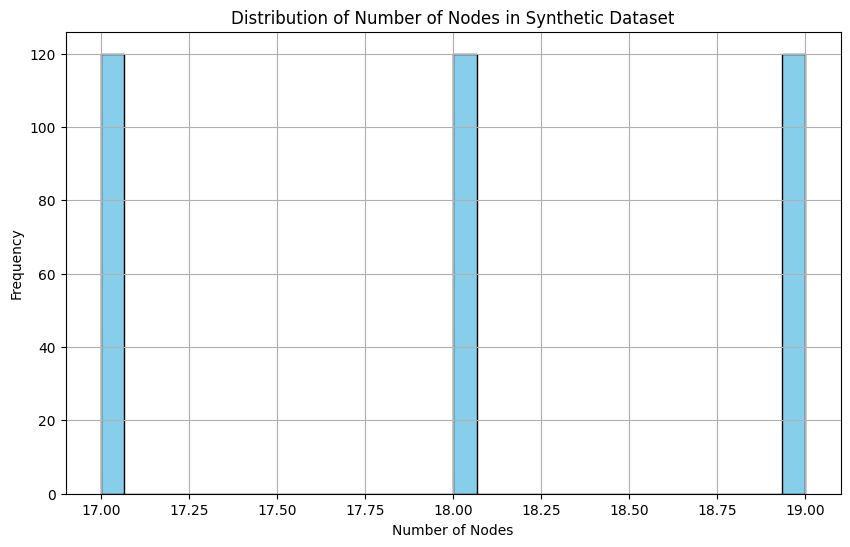

Small graphs: 360
Medium graphs: 0
Large graphs: 0


In [4]:
dataset = GraphDataset(torch.load("data/cycle_line_star_complete_1_15.pt"))

# dataset = TUDataset(
#     root="data", name="MUTAG", use_node_attr=True, transform=NormalizeFeatures()
# )

(
    small_graphs,
    medium_graphs,
    large_graphs,
    classes,
    small_classes,
    medium_classes,
    large_classes,
) = analyze_dataset(dataset)

In [5]:
def train(model, optimizer, pairs, labels, batch_size):
    model.train()
    train_losses = []
    train_accuracies = []
    losses = []
    accs = []

    for i in range(len(pairs)):
        optimizer.zero_grad()

        graph1, graph2 = pairs[i]
        label = labels[i]

        feats_1, edge_index_1 = graph1.x, graph1.edge_index
        feats_2, edge_index_2 = graph2.x, graph2.edge_index
        sizes_1 = torch.tensor([graph1.num_nodes])
        sizes_2 = torch.tensor([graph2.num_nodes])

        emb_1, emb_2, _, _, _, _ = model(
            feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
        )

        metrics = model.compute_metrics(emb_1, emb_2, torch.tensor([label]))
        loss = metrics["loss"]
        acc = metrics["acc"]

        losses.append(loss)
        accs.append(acc)

        if i % batch_size == 0 and i > 0:
            batch_loss = torch.mean(torch.stack(losses))
            batch_acc = torch.mean(torch.stack(accs))
            losses = []
            accs = []
            train_losses.append(batch_loss.detach().numpy())
            train_accuracies.append(batch_acc.detach().numpy())
            batch_loss.backward()
            optimizer.step()

In [6]:
def best_k(model, threshold=0.8):
    def calculate_cumulative_scores(scores):
        normalized_scores = F.softmax(scores, dim=0)
        cumulative_scores = torch.cumsum(normalized_scores, dim=0)
        return cumulative_scores

    def find_best_k(cumulative_scores, total_percentage):
        k = ((cumulative_scores / cumulative_scores[-1]) >= total_percentage).nonzero()[
            0
        ].item() + 1
        return k

    layer_scores_1 = []
    layer_scores_2 = []
    for i in range(len(model.topk_outputs)):
        (
            score1,
            score2,
        ) = model.topk_outputs[i]
        layer_scores_1.append(score1)
        layer_scores_2.append(score2)

    k_values_graph1 = []
    for i, scores in enumerate(layer_scores_1):
        cumulative_scores = calculate_cumulative_scores(scores)
        best_k = find_best_k(cumulative_scores, threshold)
        k_values_graph1.append(best_k)

    k_values_graph2 = []
    for i, scores in enumerate(layer_scores_2):
        cumulative_scores = calculate_cumulative_scores(scores)
        best_k = find_best_k(cumulative_scores, threshold)
        k_values_graph2.append(best_k)

    combined_ks = k_values_graph1 + k_values_graph2

    return int(round(torch.mean(torch.tensor(combined_ks, dtype=float)).item()))

In [7]:
def acc_test(model, print_results=True, k_threshold=0.8):
    ks = []

    for j in range(100):
        for i in range(dataset.num_classes):
            c = f"class_{str(i)}"
            idx1 = random.sample(range(len(classes[c])), 1)[0]
            idx2 = random.sample(range(len(classes[c])), 1)[0]
            graph1, graph2 = classes[c][idx1], classes[c][idx2]

            model.eval()

            feats_1, edge_index_1 = graph1.x, graph1.edge_index
            feats_2, edge_index_2 = graph2.x, graph2.edge_index
            sizes_1 = torch.tensor([len(graph1.x)])
            sizes_2 = torch.tensor([len(graph2.x)])
            emb1, emb2, cluster1, cluster2, layer1, layer2 = model(
                feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
            )

            k = best_k(model, k_threshold)

            ks.append(k)

    unique, counts = np.unique(ks, return_counts=True)
    results = dict(zip(unique, counts / 400))
    print(f"Selected k: {results}")

In [8]:
class NewArgs:
    def __init__(self, dim, num_layers, margin, lr, batch_size, num_pairs):
        self.dim = dim
        self.feat_dim = dataset.num_features
        self.num_layers = num_layers
        self.margin = margin
        self.lr = lr
        self.n_classes = dataset.num_classes
        self.batch_size = batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.n_clusters = 8
        self.num_pairs = num_pairs

In [9]:
hyperparams = (32, 7, 0.2, 0.01, 64, 500)
newargs = NewArgs(*hyperparams)
model = GraphMatchingNetwork(newargs)
optimizer = Adam(model.parameters(), lr=newargs.lr, weight_decay=1e-5)
pairs, labels = create_graph_pairs(dataset, newargs.num_pairs)
train(model, optimizer, pairs, labels, newargs.batch_size)

In [10]:
acc_test(model, True, 0.75)

AttributeError: 'tuple' object has no attribute 'softmax'